# Adjacency Relaxation: L∞=1 vs L∞≤2

**Purpose:** Examine how the frozen smoke graph changes when we relax our definition of adjacency.

**Question:** If we could add one edge—one adjacency that's currently missing—would disconnected components merge? Or are they genuinely far apart?

---

## The Geometry

In D dimensions, an L∞ ball of radius r contains (2r+1)^D cells. But we don't care about the combinatorial explosion—we care about our 125 actual vectors and how their connectivity changes.

- **L∞ = 1**: Adjacent = touching, including diagonals. The "strict" neighborhood.
- **L∞ ≤ 2**: Adjacent = within two hops. The "relaxed" neighborhood.

If relaxing to L∞ ≤ 2 merges components, they were "barely separate"—one diagonal hop from being connected.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from safetensors.torch import load_file
from pathlib import Path

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

# Load saved data
DATA_DIR = Path("../../tensors/Qwen3-4B-Instruct-2507")

W = load_file(DATA_DIR / "W_unembed.safetensors")['W'].view(torch.bfloat16)
masks = load_file(DATA_DIR / "masks.safetensors")
neighborhood_mask = masks['neighborhood_mask']

print(f"Loaded W: {W.shape}")
print(f"Neighborhood tokens: {neighborhood_mask.sum().item():,}")

Using device: mps
Loaded W: torch.Size([151936, 2560])
Neighborhood tokens: 2,212


In [2]:
# Build unique vectors and compute L∞ distance matrix
neighborhood_indices = torch.where(neighborhood_mask)[0]
W_neighborhood = W[neighborhood_indices]

unique_bits, inverse_indices, counts = torch.unique(
    W_neighborhood.view(torch.uint16).to(torch.int32), dim=0,
    return_inverse=True, return_counts=True
)
n_unique = len(unique_bits)
unique_bf16 = unique_bits.to(torch.uint16).view(torch.bfloat16)

# Lattice coordinates (valid for same-exponent comparisons)
def compute_lattice_coords(W_bf16):
    bits = W_bf16.view(torch.uint16).to(torch.int32)
    exponent = (bits >> 7) & 0xFF
    effective_exp = torch.where(exponent == 0, torch.ones_like(exponent), exponent)
    ulp = torch.pow(2.0, (effective_exp - 134).float())
    return W_bf16.float() / ulp

lattice_coords = compute_lattice_coords(unique_bf16)

# L∞ distance matrix
def compute_linf(a, b):
    diff = torch.abs(a.unsqueeze(1) - b.unsqueeze(0))
    return diff.max(dim=2).values

linf_matrix = compute_linf(lattice_coords, lattice_coords)

print(f"Unique vectors: {n_unique}")
print(f"Distance matrix: {linf_matrix.shape}")

Unique vectors: 125
Distance matrix: torch.Size([125, 125])


## Build Both Graphs

Now we construct two graphs with identical nodes but different edge definitions.

In [3]:
def build_graph(linf_matrix, counts, threshold_low, threshold_high):
    """
    Build a graph where edges exist if threshold_low <= L∞ <= threshold_high.
    """
    n = linf_matrix.shape[0]
    G = nx.Graph()
    
    token_counts = counts.numpy()
    for i in range(n):
        G.add_node(i, token_count=int(token_counts[i]),
                   is_black_hole=(token_counts[i] > 1))
    
    # Add edges within threshold range (excluding self)
    adj = (linf_matrix >= threshold_low) & (linf_matrix <= threshold_high) & ~torch.eye(n, dtype=torch.bool)
    edges = torch.where(adj)
    for i, j in zip(edges[0].tolist(), edges[1].tolist()):
        if i < j:
            G.add_edge(i, j, linf=linf_matrix[i, j].item())
    
    return G

# Build both graphs
G_strict = build_graph(linf_matrix, counts, 0.5, 1.5)    # L∞ = 1 only
G_relaxed = build_graph(linf_matrix, counts, 0.5, 2.5)   # L∞ ∈ {1, 2}

print(f"Strict graph (L∞=1): {G_strict.number_of_nodes()} nodes, {G_strict.number_of_edges()} edges")
print(f"Relaxed graph (L∞≤2): {G_relaxed.number_of_nodes()} nodes, {G_relaxed.number_of_edges()} edges")
print(f"New edges from relaxation: {G_relaxed.number_of_edges() - G_strict.number_of_edges()}")

Strict graph (L∞=1): 125 nodes, 100 edges
Relaxed graph (L∞≤2): 125 nodes, 280 edges
New edges from relaxation: 180


## Component Analysis

How many connected components in each graph? Do any merge?

In [4]:
def analyze_components(G, name):
    """Analyze and print component statistics."""
    components = sorted(nx.connected_components(G), key=len, reverse=True)
    
    print(f"\n{name}")
    print("=" * 60)
    print(f"Total components: {len(components)}")
    
    # Non-singleton components (size > 1)
    nontrivial = [c for c in components if len(c) > 1]
    singletons = [c for c in components if len(c) == 1]
    print(f"Non-trivial components (size > 1): {len(nontrivial)}")
    print(f"Singletons: {len(singletons)}")
    
    print(f"\nTop components:")
    for i, comp in enumerate(components[:6]):
        tokens = sum(G.nodes[n]['token_count'] for n in comp)
        bh = sum(1 for n in comp if G.nodes[n]['is_black_hole'])
        print(f"  C{i+1}: {len(comp):3d} vectors, {tokens:5,} tokens, {bh} black holes")
    
    if len(components) > 6:
        remaining_vecs = sum(len(c) for c in components[6:])
        remaining_toks = sum(sum(G.nodes[n]['token_count'] for n in c) for c in components[6:])
        print(f"  ... + {len(components)-6} more components ({remaining_vecs} vectors, {remaining_toks:,} tokens)")
    
    return components

comp_strict = analyze_components(G_strict, "STRICT (L∞ = 1)")
comp_relaxed = analyze_components(G_relaxed, "RELAXED (L∞ ≤ 2)")


STRICT (L∞ = 1)
Total components: 96
Non-trivial components (size > 1): 5
Singletons: 91

Top components:
  C1:  15 vectors, 1,070 tokens, 5 black holes
  C2:   8 vectors,   712 tokens, 2 black holes
  C3:   7 vectors,   312 tokens, 1 black holes
  C4:   2 vectors,     2 tokens, 0 black holes
  C5:   2 vectors,     6 tokens, 1 black holes
  C6:   1 vectors,     1 tokens, 0 black holes
  ... + 90 more components (90 vectors, 109 tokens)

RELAXED (L∞ ≤ 2)
Total components: 86
Non-trivial components (size > 1): 3
Singletons: 83

Top components:
  C1:  32 vectors, 1,796 tokens, 8 black holes
  C2:   8 vectors,   322 tokens, 2 black holes
  C3:   2 vectors,     6 tokens, 1 black holes
  C4:   1 vectors,     1 tokens, 0 black holes
  C5:   1 vectors,     1 tokens, 0 black holes
  C6:   1 vectors,     1 tokens, 0 black holes
  ... + 80 more components (80 vectors, 85 tokens)


## The Pencil Question: What Merged?

Let's trace exactly which strict components merged under relaxation.

In [5]:
# Map each node to its strict component index
node_to_strict_comp = {}
for i, comp in enumerate(comp_strict):
    for node in comp:
        node_to_strict_comp[node] = i

# For each relaxed component, see which strict components it contains
print("\nMERGE ANALYSIS")
print("=" * 60)
print("Which strict components merged under relaxation?\n")

for i, relaxed_comp in enumerate(comp_relaxed[:10]):  # Top 10 relaxed components
    # Find all strict components represented in this relaxed component
    strict_comps_present = set(node_to_strict_comp[n] for n in relaxed_comp)
    
    if len(strict_comps_present) > 1:
        # This relaxed component is a merger!
        merged_info = []
        for sc in sorted(strict_comps_present):
            strict_size = len(comp_strict[sc])
            merged_info.append(f"C{sc+1}({strict_size})")
        
        tokens = sum(G_relaxed.nodes[n]['token_count'] for n in relaxed_comp)
        print(f"Relaxed C{i+1} ({len(relaxed_comp)} vectors, {tokens:,} tokens):")
        print(f"  = MERGER of strict: {' + '.join(merged_info)}")
    else:
        # This relaxed component is unchanged from strict
        sc = list(strict_comps_present)[0]
        tokens = sum(G_relaxed.nodes[n]['token_count'] for n in relaxed_comp)
        if len(relaxed_comp) > 1:  # Only report non-singletons
            print(f"Relaxed C{i+1} ({len(relaxed_comp)} vectors, {tokens:,} tokens):")
            print(f"  = Strict C{sc+1} (unchanged)")


MERGE ANALYSIS
Which strict components merged under relaxation?

Relaxed C1 (32 vectors, 1,796 tokens):
  = MERGER of strict: C1(15) + C2(8) + C4(2) + C31(1) + C37(1) + C38(1) + C39(1) + C45(1) + C46(1) + C47(1)
Relaxed C2 (8 vectors, 322 tokens):
  = MERGER of strict: C3(7) + C50(1)
Relaxed C3 (2 vectors, 6 tokens):
  = Strict C5 (unchanged)


## Inter-Component Distances

For each pair of strict components, what's the minimum L∞ distance between them?

In [6]:
# Get the top non-trivial strict components
top_strict = [list(c) for c in comp_strict if len(c) > 1][:5]  # Top 5 non-trivial

print("INTER-COMPONENT MINIMUM DISTANCES (L∞)")
print("=" * 60)
print("\nMinimum L∞ distance between any pair of nodes in different components:\n")

# Build distance matrix between component pairs
n_comp = len(top_strict)
min_distances = np.zeros((n_comp, n_comp))
bridging_pairs = {}  # Store the actual nodes that form the bridge

for i in range(n_comp):
    for j in range(i+1, n_comp):
        # Find minimum distance between components i and j
        comp_i = top_strict[i]
        comp_j = top_strict[j]
        
        min_dist = float('inf')
        best_pair = None
        
        for ni in comp_i:
            for nj in comp_j:
                d = linf_matrix[ni, nj].item()
                if d < min_dist:
                    min_dist = d
                    best_pair = (ni, nj)
        
        min_distances[i, j] = min_dist
        min_distances[j, i] = min_dist
        bridging_pairs[(i, j)] = best_pair

# Print as table
header = "     " + "  ".join([f"C{i+1:2d}" for i in range(n_comp)])
print(header)
print("-" * len(header))

for i in range(n_comp):
    row = f"C{i+1:2d}  "
    for j in range(n_comp):
        if i == j:
            row += "  -  "
        else:
            row += f"{min_distances[i,j]:4.0f} "
    row += f"  ({len(top_strict[i])} vectors)"
    print(row)

INTER-COMPONENT MINIMUM DISTANCES (L∞)

Minimum L∞ distance between any pair of nodes in different components:

     C 1  C 2  C 3  C 4  C 5
----------------------------
C 1    -     2    8    2    9   (15 vectors)
C 2     2   -     8    3    8   (8 vectors)
C 3     8    8   -     8    6   (7 vectors)
C 4     2    3    8   -     8   (2 vectors)
C 5     9    8    6    8   -    (2 vectors)


In [7]:
# Show the actual bridging pairs
print("\nBRIDGING PAIRS (closest nodes between components)")
print("=" * 60)

for (i, j), (ni, nj) in sorted(bridging_pairs.items(), key=lambda x: min_distances[x[0]]):
    d = min_distances[i, j]
    tokens_i = G_strict.nodes[ni]['token_count']
    tokens_j = G_strict.nodes[nj]['token_count']
    bh_i = "BH" if G_strict.nodes[ni]['is_black_hole'] else "  "
    bh_j = "BH" if G_strict.nodes[nj]['is_black_hole'] else "  "
    
    merge_status = "→ MERGES at L∞≤2" if d <= 2 else f"  (would need L∞≤{int(d)})"
    
    print(f"C{i+1} ↔ C{j+1}: L∞ = {d:.0f}")
    print(f"         node {ni:3d} ({tokens_i:4d} tok {bh_i}) ↔ node {nj:3d} ({tokens_j:4d} tok {bh_j})")
    print(f"         {merge_status}")
    print()


BRIDGING PAIRS (closest nodes between components)
C1 ↔ C2: L∞ = 2
         node  34 (   3 tok BH) ↔ node  58 (   1 tok   )
         → MERGES at L∞≤2

C1 ↔ C4: L∞ = 2
         node  45 (   1 tok   ) ↔ node  48 (   1 tok   )
         → MERGES at L∞≤2

C2 ↔ C4: L∞ = 3
         node  64 (   1 tok   ) ↔ node  48 (   1 tok   )
           (would need L∞≤3)

C3 ↔ C5: L∞ = 6
         node  78 (   1 tok   ) ↔ node  68 (   1 tok   )
           (would need L∞≤6)

C1 ↔ C3: L∞ = 8
         node  34 (   3 tok BH) ↔ node  73 (   1 tok   )
           (would need L∞≤8)

C2 ↔ C3: L∞ = 8
         node  64 (   1 tok   ) ↔ node  73 (   1 tok   )
           (would need L∞≤8)

C2 ↔ C5: L∞ = 8
         node  64 (   1 tok   ) ↔ node  68 (   1 tok   )
           (would need L∞≤8)

C3 ↔ C4: L∞ = 8
         node  73 (   1 tok   ) ↔ node  48 (   1 tok   )
           (would need L∞≤8)

C4 ↔ C5: L∞ = 8
         node  48 (   1 tok   ) ↔ node  68 (   1 tok   )
           (would need L∞≤8)

C1 ↔ C5: L∞ = 9
         nod

## Side-by-Side Visualization

The same nodes, two different edge sets.

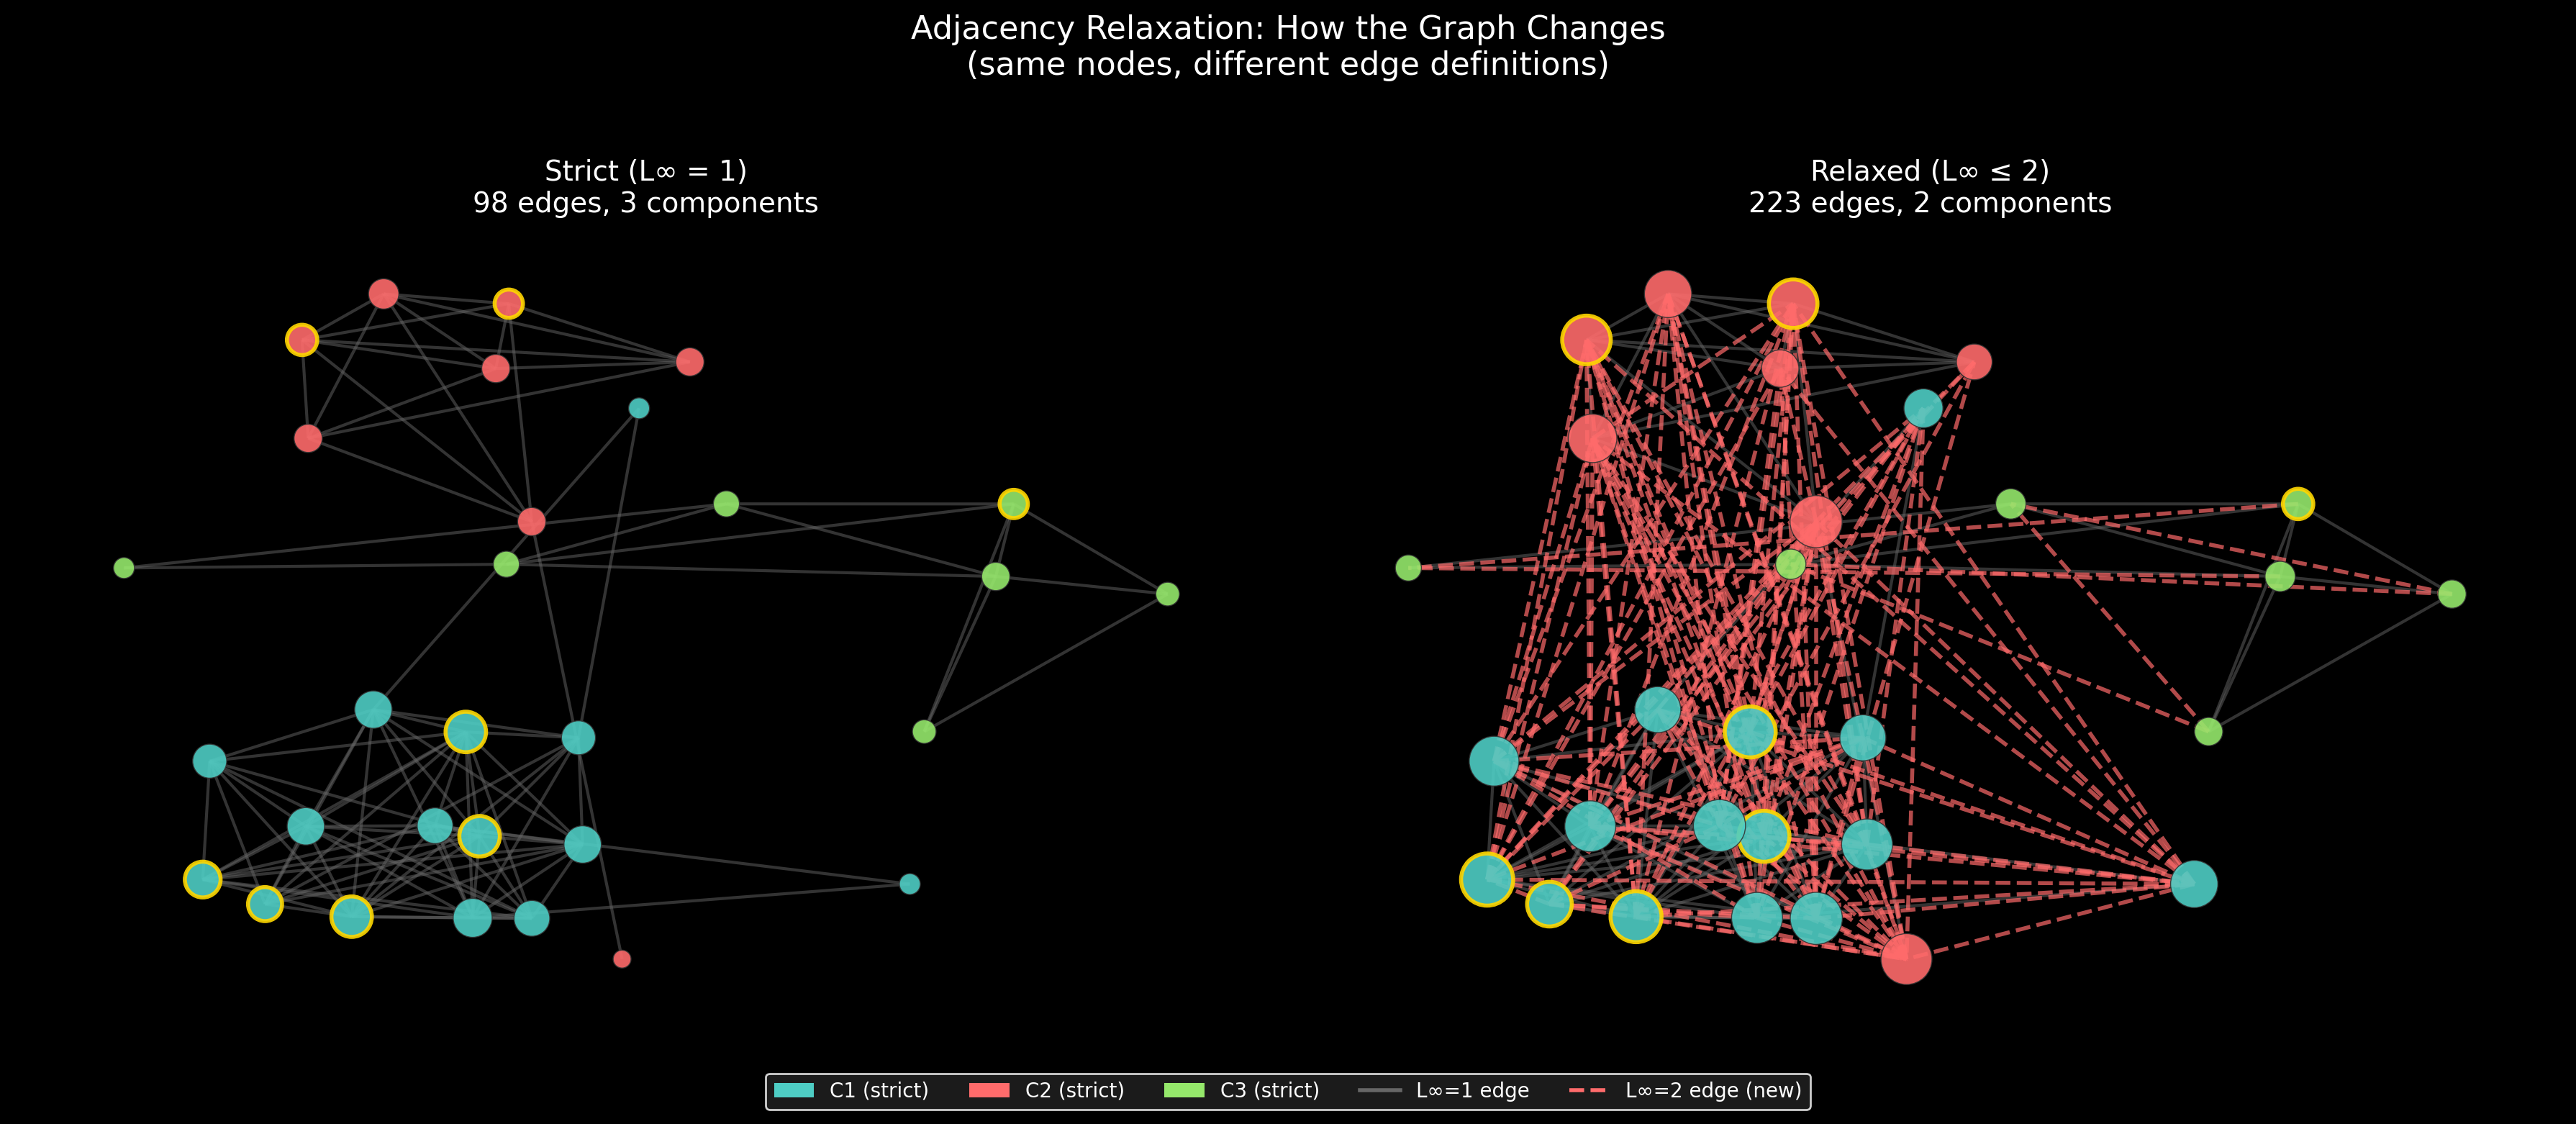

In [8]:
# Get nodes from top 3 strict components for visualization
viz_nodes = top_strict[0] + top_strict[1] + top_strict[2] if len(top_strict) >= 3 else sum(top_strict, [])

# Create subgraphs
sub_strict = G_strict.subgraph(viz_nodes).copy()
sub_relaxed = G_relaxed.subgraph(viz_nodes).copy()

# Use same layout for both (based on strict graph structure)
pos = nx.spring_layout(sub_strict, seed=42, k=2, iterations=100)

# Color nodes by their strict component
node_colors = []
component_palette = ['#4ECDC4', '#FF6B6B', '#95E86B', '#FFE66D', '#A06CD5']
for n in viz_nodes:
    for i, comp in enumerate(top_strict[:5]):
        if n in comp:
            node_colors.append(component_palette[i])
            break

fig, axes = plt.subplots(1, 2, figsize=(18, 8), dpi=200)
fig.patch.set_facecolor('black')

for ax, G_sub, title in [(axes[0], sub_strict, 'Strict (L∞ = 1)'),
                          (axes[1], sub_relaxed, 'Relaxed (L∞ ≤ 2)')]:
    ax.set_facecolor('black')
    
    # Identify new edges (only in relaxed)
    strict_edges = set(G_strict.subgraph(viz_nodes).edges())
    
    # Separate old and new edges
    old_edges = [e for e in G_sub.edges() if e in strict_edges or (e[1], e[0]) in strict_edges]
    new_edges = [e for e in G_sub.edges() if e not in strict_edges and (e[1], e[0]) not in strict_edges]
    
    # Draw old edges
    nx.draw_networkx_edges(G_sub, pos, edgelist=old_edges, ax=ax,
                           alpha=0.5, edge_color='#666666', width=1.5)
    
    # Draw new edges (only visible in relaxed graph)
    if new_edges:
        nx.draw_networkx_edges(G_sub, pos, edgelist=new_edges, ax=ax,
                               alpha=0.7, edge_color='#ff6b6b', width=2, style='dashed')
    
    # Node properties
    sizes = [50 + G_sub.degree(n) * 30 for n in viz_nodes]
    is_bh = [G_strict.nodes[n]['is_black_hole'] for n in viz_nodes]
    
    # Draw nodes
    nx.draw_networkx_nodes(G_sub, pos, nodelist=viz_nodes, ax=ax,
                           node_size=sizes, node_color=node_colors, alpha=0.9,
                           edgecolors=['gold' if bh else '#333333' for bh in is_bh],
                           linewidths=[2 if bh else 0.5 for bh in is_bh])
    
    # Count components in this subgraph
    n_components = nx.number_connected_components(G_sub)
    
    ax.set_title(f'{title}\n{G_sub.number_of_edges()} edges, {n_components} components',
                 fontsize=14, color='white')
    ax.axis('off')

# Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='#4ECDC4', label='C1 (strict)'),
    Patch(facecolor='#FF6B6B', label='C2 (strict)'),
    Patch(facecolor='#95E86B', label='C3 (strict)'),
    Line2D([0], [0], color='#666666', linewidth=2, label='L∞=1 edge'),
    Line2D([0], [0], color='#ff6b6b', linewidth=2, linestyle='dashed', label='L∞=2 edge (new)'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=5,
           facecolor='#222222', edgecolor='white', labelcolor='white',
           fontsize=10, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Adjacency Relaxation: How the Graph Changes\n'
             '(same nodes, different edge definitions)',
             fontsize=16, color='white', y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig('../../notebooks/analysis/adjacency_relaxation.png',
            dpi=200, bbox_inches='tight', facecolor='black')
plt.show()

## Summary Table

In [9]:
print("="*70)
print("ADJACENCY RELAXATION SUMMARY")
print("="*70)
print()
print(f"{'Metric':<35} {'L∞=1':>15} {'L∞≤2':>15}")
print("-"*70)
print(f"{'Total edges':<35} {G_strict.number_of_edges():>15,} {G_relaxed.number_of_edges():>15,}")
print(f"{'Total components':<35} {nx.number_connected_components(G_strict):>15,} {nx.number_connected_components(G_relaxed):>15,}")

nontrivial_strict = len([c for c in comp_strict if len(c) > 1])
nontrivial_relaxed = len([c for c in comp_relaxed if len(c) > 1])
print(f"{'Non-trivial components (size > 1)':<35} {nontrivial_strict:>15,} {nontrivial_relaxed:>15,}")

largest_strict = max(len(c) for c in comp_strict)
largest_relaxed = max(len(c) for c in comp_relaxed)
print(f"{'Largest component (vectors)':<35} {largest_strict:>15,} {largest_relaxed:>15,}")

print()
print(f"New edges from relaxation: {G_relaxed.number_of_edges() - G_strict.number_of_edges()}")
print(f"Components that merged: see analysis above")

ADJACENCY RELAXATION SUMMARY

Metric                                         L∞=1            L∞≤2
----------------------------------------------------------------------
Total edges                                     100             280
Total components                                 96              86
Non-trivial components (size > 1)                 5               3
Largest component (vectors)                      15              32

New edges from relaxation: 180
Components that merged: see analysis above


## Connectivity Threshold and Diameter

Two related but different questions:

1. **Connectivity threshold**: What's the minimum L∞ such that all 125 vectors form ONE connected component?
2. **Complete graph threshold**: What's the minimum L∞ such that EVERY pair is adjacent? (The true diameter.)

In [10]:
import pandas as pd

# Question 2 first (easy): What's the max pairwise distance?
# This is the diameter - the L∞ needed for a complete graph
linf_no_diag = linf_matrix.clone()
linf_no_diag.fill_diagonal_(0)
diameter = linf_no_diag.max().item()

print(f"COMPLETE GRAPH THRESHOLD (diameter): L∞ ≤ {diameter:.0f}")
print(f"  → At this threshold, every pair of vectors would be adjacent")
print()

# Question 1: Sweep L∞ thresholds and find when we hit 1 component
thresholds = list(range(1, int(diameter) + 2))
results = []

for thresh in thresholds:
    G = build_graph(linf_matrix, counts, 0.5, thresh + 0.5)
    n_comp = nx.number_connected_components(G)
    n_edges = G.number_of_edges()
    largest = max(len(c) for c in nx.connected_components(G))
    
    results.append({
        'L∞ threshold': thresh,
        'Components': n_comp,
        'Edges': n_edges,
        'Largest component': largest,
        'Connected?': '✓' if n_comp == 1 else ''
    })

df = pd.DataFrame(results)
print("CONNECTIVITY VS L∞ THRESHOLD")
print("=" * 60)
print(df.to_string(index=False))
print()

# Find the critical threshold
critical = df[df['Components'] == 1]['L∞ threshold'].min()
print(f"CONNECTIVITY THRESHOLD: L∞ ≤ {critical}")
print(f"  → This is the minimum L∞ to make all 125 vectors one connected component")

COMPLETE GRAPH THRESHOLD (diameter): L∞ ≤ 508
  → At this threshold, every pair of vectors would be adjacent



CONNECTIVITY VS L∞ THRESHOLD
 L∞ threshold  Components  Edges  Largest component Connected?
            1          96    100                 15           
            2          86    280                 32           
            3          85    380                 33           
            4          82    486                 34           
            5          81    540                 34           
            6          81    575                 34           
            7          81    596                 34           
            8          79   1019                 47           
            9          78   1044                 48           
           10          78   1066                 48           
           11          78   1084                 48           
           12          78   1099                 48           
           13          78   1110                 48           
           14          76   1125                 49           
           15          76 

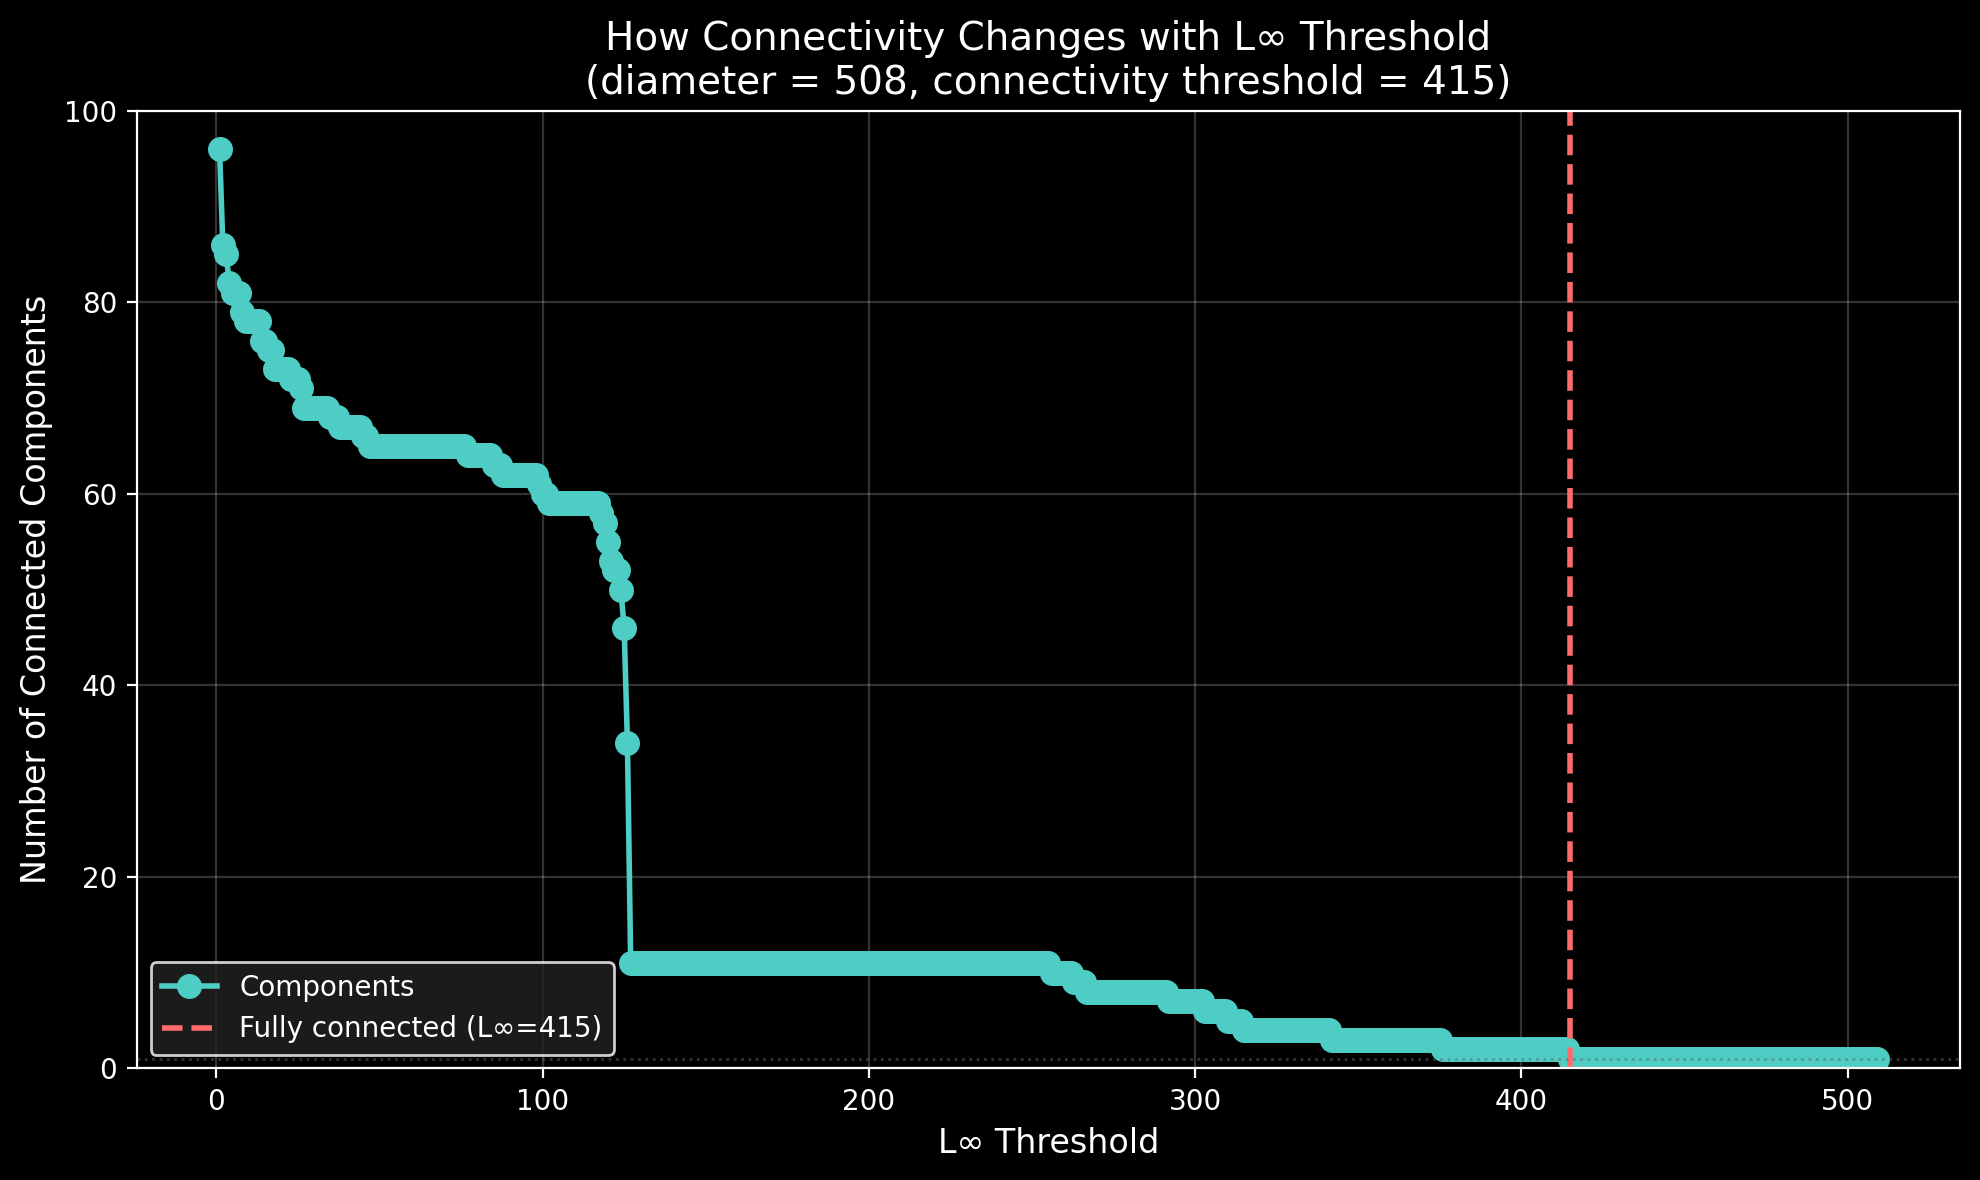

In [11]:
# Visualize the connectivity curve
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

ax.plot(df['L∞ threshold'], df['Components'], 'o-', color='#4ECDC4', 
        linewidth=2, markersize=8, label='Components')

# Mark the critical threshold
ax.axvline(x=critical, color='#FF6B6B', linestyle='--', linewidth=2, 
           label=f'Fully connected (L∞={critical})')
ax.axhline(y=1, color='#666666', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('L∞ Threshold', fontsize=12, color='white')
ax.set_ylabel('Number of Connected Components', fontsize=12, color='white')
ax.set_title('How Connectivity Changes with L∞ Threshold\n'
             f'(diameter = {diameter:.0f}, connectivity threshold = {critical})',
             fontsize=14, color='white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white')
ax.grid(True, alpha=0.2, color='white')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../../notebooks/analysis/connectivity_threshold.png',
            dpi=200, bbox_inches='tight', facecolor='black')
plt.show()

## Interpretation

The frozen smoke's three main components at L∞=1 are separated by remarkably small distances in the lattice. This tells us something about how the structure formed—these vectors started close together (possibly from initialization) and stayed close, but not *quite* close enough to be adjacent.

The "Mormons dancing" metaphor holds: they're at arm's length, aware of each other, but not touching.

**Key numbers:**
- **Connectivity threshold**: The minimum L∞ to make all vectors one connected component
- **Diameter**: The maximum L∞ distance between any two vectors (complete graph threshold)